In [403]:
import numpy as np
import pandas as pd
%matplotlib inline
import summarytools as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

In [ ]:
#Importing the data
HIV_df=pd.read_csv(r'C:\Users\rkeoye\Documents\AUDIT_2024\DATA_SCIENCE\PHASE  5\dreams_raw_dataset.csv')
HIV_df.head()#display the first 5 rows of the dataset

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\rkeoye\\Documents\\AUDIT_2024\\DATA_SCIENCE\\PHASE 5\\dreams_raw_dataset.csv'

In [ ]:
HIV_df.info()#Getting more information about the dataset
'''The dataset contains 455,807 rows and42 fields Made of the following data types: Float (8 columns, object (29) and int(5))'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455807 entries, 0 to 455806
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   date_of_birth                      455807 non-null  object 
 1   date_of_enrollment                 455806 non-null  object 
 2   county                             446551 non-null  object 
 3   head_of_household                  446192 non-null  object 
 4   head_of_household_other            5960 non-null    object 
 5   age_of_household_head              434789 non-null  float64
 6   father_alive                       442399 non-null  object 
 7   mother_alive                       442820 non-null  object 
 8   are_both_parents_alive             455807 non-null  object 
 9   is_one_parent_alive                455807 non-null  object 
 10  parents_alive_status               390403 non-null  object 
 11  no_of_people_in_household          4486

'The dataset contains 455,807 rows and42 fields Made of the following data types: Float (8 columns, object (29) and int(5))'

In [ ]:
st.dfSummary(HIV_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date_of_birth[object],1. 1/1/20002. 1/1/20023. 1/1/19984. 1/1/20015. 1/1/19996. 1/1/19967. 1/1/19978. 1/1/19949. 1/1/200310. 1/1/199511. other,"1,011 (0.2%)993 (0.2%)904 (0.2%)883 (0.2%)875 (0.2%)794 (0.2%)756 (0.2%)614 (0.1%)551 (0.1%)509 (0.1%)447,917 (98.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADaElEQVR4nO3cQWoUYRRG0VehiWbSTQhkCbqHLMLFuohehHsIITUwMZNyIIo41lvQnjPK8B9ceDTUl2XbtoHC1d4P4P8hNjJiIyM2MmIjIzYyYiMjNjJiIyM2MlfLsnxcluX93g/h8l3NzIeZebf3Q7h8zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbmamS8z823vh3D5Fv/FiIozSkZsZKyryFhXkXFGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQMXgh44ySERsZgxcyBi9knFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERkZsZKyryFhXkXFGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4i44ySERsZgxcyBi9knFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4i44ySERsZ6yoy1lVknFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMs4oGbGRERsZ6yoy1lVknFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWSsq8g4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMs4omWVmbmbmeu+HcLHetm17mZk53N3dfToej7d7v4jLtK7r07Isn7dtezkcj8fbh4eHl9Pp9Lr3w7gsz8/P78/n8+3j4+P1zLwcZmZOp9Pr/f39153fxmW6+fmHHwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDjM/PgXZ+yFcnj+7Oqzr+nQ+n2/nt09B4G9Z1/VpZt5mfBbOv/frs3DrKjJ+IJARGxmxkREbGbGRERsZsZERGxmxkfkOCvhuJDOJMoEAAAAASUVORK5CYII="">",0(0.0%)
2,date_of_enrollment[object],1. 12/9/20202. 12/2/20203. 12/3/20204. 8/23/20175. 12/7/20206. 8/28/20177. 12/10/20208. 12/4/20209. 12/15/202010. 8/25/201711. other,"1,795 (0.4%)1,786 (0.4%)1,723 (0.4%)1,712 (0.4%)1,707 (0.4%)1,691 (0.4%)1,683 (0.4%)1,673 (0.4%)1,671 (0.4%)1,634 (0.4%)438,732 (96.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfUlEQVR4nO3cMWobUQBF0S8jTNyMEAItRovwYrMI7UYITREbN0oRpwhRAgH7DijnVCHVFJfR5PNfVtfrdUDhYekH4P8hNjJiIyM2MmIjIzYyYiMjNjJiI7MaYzyNMcb1en1Z+Fm4c+vdbvc8xhir1eqr4PhMD9M0badp2o4xHpd+GO6bbzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI7Oe5/n8/ue3RZ+Eu2eDQGblv8yi4s1GxrqKjHUVGUcfZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IuBZOxuCFjDcbGYMXMgYvZBx9kBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXgh41o4GYMXMr7ZyPgZJWNdRca6ioxvNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZFwLJ2NdRcabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxlvNjIGL2QMXsg4+iAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZGwQyFhXkfFmI2NdRca6ioyjDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZFwLJ2PwQsabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxnfbGT8jJKxriJjXUXGNxsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjKuhZOxriLjzUbG4IWMwQsZRx9kxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsi4Fk7G4IXMzzebK+F8pLdbv5Tr3W73/L5BgA8xz/P51oBqPU3T9nA4vGw2m9elHo77cblcvhyPx+3pdHocY/wa2xhjbDab1/1+/22Rp+MePd36S+dsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZNZj/LgWsvSDcB/+1tJ6nufz8Xjcjj9cC4F/9T6i+m1A5Vo4n+HmtXCDFzL+gUBGbGTERkZsZMRGRmxkxEZGbGTERuY7CLkQJ3942gEAAAAASUVORK5CYII="">",1(0.0%)
3,county[object],1. Nairobi2. Kisumu3. Homabay4. Migori5. Siaya6. Mombasa7. Kiambu8. nan,"100,411 (22.0%)82,909 (18.2%)79,954 (17.5%)69,846 (15.3%)60,411 (13.3%)31,890 (7.0%)21,130 (4.6%)9,256 (2.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADS0lEQVR4nO3dQWrbaACG4d/FlOnGJgRyGB9iDjuH8G1CiBaT0o1nMQ1kpk2b1NIrqJ5nl5W1ePmNhL54d7lcBhQ+rH0BbIfYyIiNjNjIiI2M2Mjsxhifxhg

In [ ]:
#Numerical columns
numerical_cols = HIV_df.select_dtypes(include=[np.number]).columns

#Checking for outliers using IQR (Interquartile Range) method
outliers_iqr = {}

for col in numerical_cols:
    Q1 = HIV_df[col].quantile(0.25)
    Q3 = HIV_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = HIV_df[(HIV_df[col] < lower_bound) | (HIV_df[col] > upper_bound)]
    outliers_iqr[col] = outliers.shape[0]  # Count of outliers for each column

#Checking for outliers using Z-score method
from scipy.stats import zscore

outliers_zscore = {}

for col in numerical_cols:
    # Calculate the Z-scores for each value in the column
    z_scores = zscore(HIV_df[col].dropna())
    
    # Identify outliers (Z-score > 3 or < -3)
    outliers = np.where(np.abs(z_scores) > 3)[0]
    outliers_zscore[col] = len(outliers)  # Count of outliers for each column

#Combine results
outliers_summary = pd.DataFrame({
    'Outliers (IQR)': outliers_iqr,
    'Outliers (Z-score)': outliers_zscore
})

print(outliers_summary)


                               Outliers (IQR)  Outliers (Z-score)
age_of_household_head                    6374                   9
no_of_people_in_household                8968                 551
no_of_females                            6495                 673
no_of_males                              6147                1215
no_of_adults                            31006                6045
no_of_children                          14999                 410
age_at_first_sexual_encounter            4666                  49
bio_medical                              4276                4276
social_protection                        5422                5422
behavioral                              53648                   0
post_gbv_care                           88147                   0
other_interventions                     27853               27853
exit_age                                 1230                 134


In [ ]:
# Define the list of columns to handle (excluding 'age_at_first_sexual_encounter')
columns_to_handle = [
    'age_of_household_head', 
    'no_of_people_in_household', 
    'no_of_females', 
    'no_of_males', 
    'no_of_adults', 
    'no_of_children', 
    'bio_medical', 
    'social_protection', 
    'behavioral', 
    'post_gbv_care', 
    'other_interventions', 
    'exit_age',
    'age_at_first_sexual_encounter'
]

# Handling outliers by replacing them with the median value
def handle_outliers_with_median(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Using boolean masking to replace outliers with the median
        median_value = df[col].median()
        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_value

    return df

# Handle the outliers by replacing them with median values
HIV_df = handle_outliers_with_median(HIV_df, columns_to_handle)

# Optional: Check the cleaned DataFrame
print(HIV_df[columns_to_handle].describe())

       age_of_household_head  no_of_people_in_household  no_of_females  \
count          434789.000000              448607.000000  448475.000000   
mean               42.086042                   5.594300       3.224177   
std                11.992954                   2.120252       1.385272   
min                 8.000000                   0.000000       0.000000   
25%                33.000000                   4.000000       2.000000   
50%                42.000000                   6.000000       3.000000   
75%                50.000000                   7.000000       4.000000   
max                75.000000                  11.000000       7.000000   

         no_of_males   no_of_adults  no_of_children  bio_medical  \
count  448125.000000  448328.000000   448034.000000     455807.0   
mean        2.352337       2.234525        3.053753          1.0   
std         1.366414       0.796930        1.733543          0.0   
min         0.000000       1.000000        0.000000          

In [ ]:
#confirm duplicates and drop them
print(HIV_df.duplicated().sum())
HIV_df = HIV_df.drop_duplicates()

106


In [ ]:
missing_values=HIV_df.isna().sum().sort_values(ascending=False)
total_rows=HIV_df.shape[0]
missing_values_percentage=((missing_values/total_rows)*100).round(1)
missing_values_percentage

head_of_household_other              98.7
dreams_program_other                 98.6
exit_reason_other                    94.4
dreams_program                       89.8
used_condom_with_last_partner        53.4
age_of_last_partner                  53.4
age_at_first_sexual_encounter        50.4
has_sexual_partner                   50.3
current_school_level                 44.1
no_of_days_missed_food_in_4wks       43.7
current_income_source                28.4
exit_reason                          15.3
exit_age                             15.1
parents_alive_status                 14.3
age_of_household_head                 4.6
father_alive                          2.9
mother_alive                          2.8
head_of_household                     2.1
county                                2.0
no_of_children                        1.7
ever_had_sex                          1.7
no_of_males                           1.7
no_of_adults                          1.6
no_of_females                     

In [ ]:
#Drop columns with % null values above 80%
above_threshold = missing_values_percentage[missing_values_percentage > 80.0]
#print(missing_values_percentage)
print("\nColumns with missing values above 80% threshold:")
print(above_threshold)



Columns with missing values above 80% threshold:
head_of_household_other    98.7
dreams_program_other       98.6
exit_reason_other          94.4
dreams_program             89.8
dtype: float64


In [ ]:
#drop columns that we may not need for our analysis
columns_to_drop=['ever_tested_for_hiv',
                 'is_one_parent_alive', 'parents_alive_status', 'no_of_females',
                 'exit_age']
AGYW_prev_data=HIV_df.drop(columns=columns_to_drop)

In [ ]:
# Filling missing values for categorical and numerical columns
numerical_cols = HIV_df.select_dtypes(include=np.number).columns
print(f'numerical columns: {numerical_cols}')
categorical_cols = HIV_df.select_dtypes(include='object').columns
print(f'categorical columns:  {categorical_cols}')

# Fill missing values
for col in HIV_df.columns:
    if col in numerical_cols:
        HIV_df[col].fillna(HIV_df[col].median(), inplace=True)  # Fill numerical columns missing values with median
    elif col in categorical_cols:
        most_frequent = HIV_df[col].mode()[0] if not HIV_df[col].mode().empty else "Unknown"
        HIV_df[col].fillna(most_frequent, inplace=True)  # Fill categorical colums missing values with mode or "Unknown"

numerical columns: Index(['age_of_household_head', 'no_of_people_in_household', 'no_of_females',
       'no_of_males', 'no_of_adults', 'no_of_children',
       'age_at_first_sexual_encounter', 'bio_medical', 'social_protection',
       'behavioral', 'post_gbv_care', 'other_interventions', 'exit_age'],
      dtype='object')
categorical columns:  Index(['date_of_birth', 'date_of_enrollment', 'county', 'head_of_household',
       'head_of_household_other', 'father_alive', 'mother_alive',
       'are_both_parents_alive', 'is_one_parent_alive', 'parents_alive_status',
       'ever_missed_full_day_food_in_4wks', 'no_of_days_missed_food_in_4wks',
       'currently_in_school', 'current_school_level', 'current_income_source',
       'ever_tested_for_hiv', 'last_test_result', 'ever_had_sex',
       'has_sexual_partner', 'age_of_last_partner',
       'used_condom_with_last_partner', 'dreams_program',
       'dreams_program_other', 'exit_status', 'exit_reason',
       'intervention_name', 'interve

C:\Users\rkeoye\AppData\Local\Temp\ipykernel_10504\3506639590.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  HIV_df[col].fillna(most_frequent, inplace=True)  # Fill categorical colums missing values with mode or "Unknown"
C:\Users\rkeoye\AppData\Local\Temp\ipykernel_10504\3506639590.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

In [ ]:
HIV_df.describe(include=object)

,date_of_birth,date_of_enrollment,county,head_of_household,head_of_household_other,father_alive,mother_alive,are_both_parents_alive,is_one_parent_alive,parents_alive_status,...,age_of_last_partner,used_condom_with_last_partner,dreams_program,dreams_program_other,exit_status,exit_reason,intervention_name,intervention_date,result,exit_reason_other
count,455701,455701,455701,455701,455701,455701,455701,455701,455701,455701,...,455701,455701,455701,455701,455701,455701,455701,455701,455701,455701
unique,7839,2604,7,8,550,3,3,2,2,2,...,3,3,1111,4175,2,7,1,2826,2,1241
top,1/1/2000,12/9/2020,Nairobi,Father,Guardian,Yes,Yes,Yes,No,Both,...,Older,Sometimes,Health Choices for a Better Future (HCBF or HC1),SASA,Yes,Graduation,HTS - HTS (Client),8/18/2018,Negative,Graduated
freq,1010,1795,109650,182678,450331,309175,391790,273136,338518,338518,...,397881,339333,419836,449394,381938,398181,455701,4734,454682,438905


In [ ]:
# converting date columns to dateline 
date_cols= ['date_of_birth', 'date_of_enrollment','intervention_date']
for col in date_cols:
    HIV_df[col] = pd.to_datetime(HIV_df[col])

In [ ]:
#Standardize categorical variables that have binary responses (e.g., Yes/No)
binary_cols = ['father_alive', 'mother_alive', 'ever_missed_full_day_food_in_4wks', 'currently_in_school', 'ever_had_sex', 'has_sexual_partner', 
               'used_condom_with_last_partner']
for col in binary_cols:
    if col in HIV_df.columns:
        # Convert to lower case for consistency
        HIV_df[col] = HIV_df[col].str.lower()
        # Replace common variations with standardized 'yes' or 'no'
        HIV_df[col] = HIV_df[col].replace({'yes': 'yes', 'no': 'no', 'y': 'yes', 'n': 'no'})

# print the first few rows 
HIV_df[['father_alive', 'mother_alive', 'ever_missed_full_day_food_in_4wks', 'currently_in_school','ever_had_sex', 'has_sexual_partner', 
               'used_condom_with_last_partner']].head()

,father_alive,mother_alive,ever_missed_full_day_food_in_4wks,currently_in_school,ever_had_sex,has_sexual_partner,used_condom_with_last_partner
0,yes,yes,no,yes,no,yes,sometimes
1,yes,yes,no,yes,no,yes,sometimes
2,no,yes,yes,yes,no,yes,sometimes
3,no,yes,no,yes,no,yes,sometimes
4,yes,yes,no,yes,no,yes,sometimes


In [ ]:
# Creating a new column 'year' by extracting the year from 'date_of_enrollment'
HIV_df['year_of_enrollment'] = HIV_df['date_of_enrollment'].dt.year

# Displaying the first few rows to verify the new column
HIV_df[['date_of_enrollment', 'year_of_enrollment']].head()

,date_of_enrollment,year_of_enrollment
0,2020-02-22,2020
1,2019-12-18,2019
2,2020-03-07,2020
3,2020-03-03,2020
4,2019-12-18,2019


In [ ]:
# Calculate age at enrollment using the birth and enrollment dates
def calculate_age(row):
    dob = row['date_of_birth']
    doe = row['date_of_enrollment']
    # Return NaN if either date is missing
    if pd.isnull(dob) or pd.isnull(doe):
        return np.nan
    # Compute the basic difference in years
    age = doe.year - dob.year
    # Adjust if the birthday has not yet occurred in the enrollment year
    if (doe.month, doe.day) < (dob.month, dob.day):
        age -= 1
    return age

# Apply the function to create a new column 'age_at_enrollment'
HIV_df['age_at_enrollment'] = HIV_df.apply(calculate_age, axis=1)

# Calculate the mean age (ignoring missing values)
mean_age = HIV_df['age_at_enrollment'].mean()

# Display the first few rows to verify the result
HIV_df[['date_of_birth', 'date_of_enrollment', 'age_at_enrollment']].head()

,date_of_birth,date_of_enrollment,age_at_enrollment
0,2004-09-16,2020-02-22,15
1,2004-08-02,2019-12-18,15
2,2005-10-20,2020-03-07,14
3,2006-01-18,2020-03-03,14
4,2004-03-22,2019-12-18,15


In [ ]:
# Creating age groups by defining bins and labels for the age groups
bins = [5, 10, 15, 20, 25, float('inf')]
labels = ["5-9", "10-14", "15-19", "20-24", "Over 24"]

# Create the new column 'age_group' based on 'age_at_enrollment'
HIV_df['age_group'] = pd.cut(HIV_df['age_at_enrollment'], bins=bins, right=False, labels=labels)

# Display the distribution of the new age groups
age_group_distribution = HIV_df['age_group'].value_counts().sort_index()
age_group_distribution

age_group
5-9          2470
10-14       63701
15-19      228881
20-24      160563
Over 24        86
Name: count, dtype: int64

In [ ]:
#Numerical columns
numerical_cols= HIV_df.select_dtypes(include=np.number).columns

#Checking for outliers using IQR (Interquartile Range) method
outliers_iqr = {}

for col in numerical_cols:
    Q1 = HIV_df[col].quantile(0.25)
    Q3 = HIV_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = HIV_df[(HIV_df[col] < lower_bound) | (HIV_df[col] > upper_bound)]
    outliers_iqr[col] = outliers.shape[0]  # Count of outliers for each column

#Checking for outliers using Z-score method
from scipy.stats import zscore

outliers_zscore = {}

for col in numerical_cols:
    # Calculate the Z-scores for each value in the column
    z_scores = zscore(HIV_df[col].dropna())
    
    # Identify outliers (Z-score > 3 or < -3)
    outliers = np.where(np.abs(z_scores) > 3)[0]
    outliers_zscore[col] = len(outliers)  # Count of outliers for each column

#Combine results
outliers_summary = pd.DataFrame({
    'Outliers (IQR)': outliers_iqr,
    'Outliers (Z-score)': outliers_zscore
})

print(outliers_summary)

                               Outliers (IQR)  Outliers (Z-score)
age_of_household_head                     921                   0
no_of_people_in_household                   0                   0
no_of_females                               0                   0
no_of_males                                 0                   0
no_of_adults                                0                   0
no_of_children                              0                   0
age_at_first_sexual_encounter          185213                7907
bio_medical                                 0                   0
social_protection                           0                   0
behavioral                                  0                   0
post_gbv_care                               0                   0
other_interventions                         0                   0
exit_age                                    0                 167
year_of_enrollment                          0                   0
age_at_enr

In [ ]:
# Define the list of columns to handle (excluding 'age_at_first_sexual_encounter')
columns_to_handle = [
    'age_of_household_head', 
    'no_of_people_in_household',  
    'no_of_males', 
    'no_of_adults', 
    'no_of_children', 
    'bio_medical', 
    'social_protection', 
    'behavioral', 
    'other_interventions'
]

# Handling outliers by replacing them with the median value
def handle_outliers_with_median(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Using boolean masking to replace outliers with the median
        median_value = df[col].median()
        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_value

    return df

# Handle the outliers by replacing them with median values
HIV_df = handle_outliers_with_median(HIV_df, columns_to_handle)

# Optional: Check the cleaned DataFrame
HIV_df[columns_to_handle].describe().T

,count,mean,std,min,25%,50%,75%,max
age_of_household_head,455701.0,42.022574,11.619147,10.0,34.0,42.0,50.0,74.0
no_of_people_in_household,455701.0,5.600510,2.104051,0.0,4.0,6.0,7.0,11.0
no_of_males,455701.0,2.346361,1.355601,0.0,1.0,2.0,3.0,6.0
no_of_adults,455701.0,2.230682,0.790930,1.0,2.0,2.0,3.0,4.0
no_of_children,455701.0,3.052690,1.718701,0.0,2.0,3.0,4.0,7.0
bio_medical,455701.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
social_protection,455701.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
behavioral,455701.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
other_interventions,455701.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


DATA PREPROCESSING

In [ ]:
clean_df=HIV_df
clean_df = clean_df.drop(columns=['date_of_birth','date_of_enrollment','year_of_enrollment']).copy()
# Identify categorical and numerical columns
categorical_cols = clean_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols= [col for col in categorical_cols if col != 'result']
numerical_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [ ]:
# Preprocessing pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
      
    ('ohe', OneHotEncoder(handle_unknown='ignore')) 
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])


In [ ]:
# Split the dataset into train and test sets
X = clean_df.drop(columns=['result'])
y = clean_df['result'].map({"Positive": 1, "Negative": 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

MODELING

BASE MODEL: LOGISTIC REGRESSION

In [ ]:
#Baseline model as logistic regression
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced'))
])

In [ ]:
#Fit baseline model
lr_model.fit(X_train, y_train)

c:\Users\rkeoye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age_of_household_head',
                                                   'no_of_people_in_household',
                                                   'no_of_females',
                                                   'no_of_males',
                                                   'no_of_adults',
                                                   'no_of_children',
                                                   'age_at_first_sexual_encounter',
                                                   'bio_medical',
                                                   'social_protection',
                                                   'behavioral',
                                                   'post_gbv_care',
                                                   'other_interventions',
                                                   '...
                                                   'currently_in_school',
                                                   'current_school_level',
                                                   'current_income_source',
                                                   'ever_tested_for_hiv',
                                                   'last_test_result',
                                                   'ever_had_sex',
                                                   'has_sexual_partner',
                                                   'age_of_last_partner',
                                                   'used_condom_with_last_partner',
                                                   'dreams_program',
                                                   'dreams_program_other',
                                                   'exit_status', 'exit_reason',
                                                   'intervention_name',
                                                   'exit_reason_other'])])),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [ ]:
#Make predictions
y_pred = lr_model.predict(X_test)

In [ ]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Accuracy: 72.87%
Precision: 0.50%
Recall: 61.27%
F1 Score: 1.00%


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[66290 24647]
 [   79   125]]


In [ ]:

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd
import scipy.sparse as sp

# Separate features and target
X = clean_df.drop(columns=['result'])
y = clean_df['result']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Apply preprocessing (keep sparse format)
X_preprocessed = preprocessor.fit_transform(X)

# Ensure sparse format for efficient SMOTE
if sp.issparse(X_preprocessed):
    X_preprocessed = X_preprocessed.tocsr()  # Convert to Compressed Sparse Row (CSR) format

# Apply SMOTE (Use a limited subset to avoid excessive memory usage)
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y_encoded)

# Convert resampled data back to sparse (avoid dense conversion)
X_resampled_sparse = sp.csr_matrix(X_resampled)

# Convert sparse matrix to DataFrame
balanced_df = pd.DataFrame.sparse.from_spmatrix(X_resampled_sparse, columns=preprocessor.get_feature_names_out())
balanced_df['result'] = le.inverse_transform(y_resampled)  # Convert back to original labels

# Display new class distribution
print("New Class Distribution (%):")
print(balanced_df['result'].value_counts(normalize=True) * 100)


New Class Distribution (%):
result
Negative    90.909127
Positive     9.090873
Name: proportion, dtype: float64


In [ ]:
# Separate features and target
X_balanced = balanced_df.drop(columns=['result'])
y_balanced = balanced_df['result']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (400120, 7162)
Testing set size: (100030, 7162)


In [ ]:
#Train the model
# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=500, random_state=42)

# Train model
log_reg.fit(X_train, y_train)
# Predict class labels
y_pred = log_reg.predict(X_test)

# Predict probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability of the positive class
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate model performance
print("📊 **Logistic Regression Performance**")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label='Positive'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label='Positive'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label='Positive'):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")



📊 **Logistic Regression Performance**
Accuracy: 0.9124
Precision: 0.6532
Recall: 0.0783
F1 Score: 0.1398
AUC-ROC: 0.8028


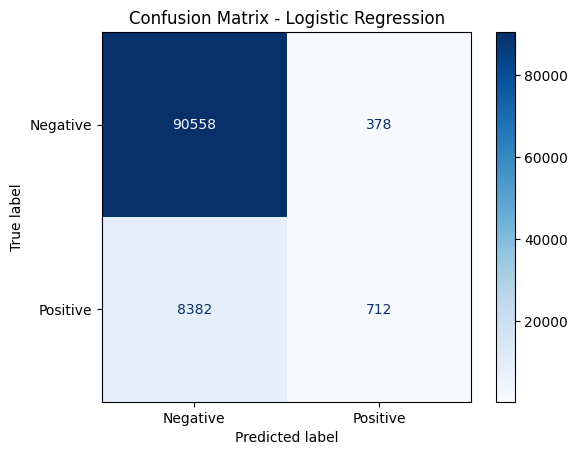

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Negative', 'Positive'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')

# Show the plot
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


RANDOM FOREST CLASSIFIER

In [ ]:
# Convert string labels to numeric (0: Negative, 1: Positive)
label_mapping = {'Negative': 0, 'Positive': 1}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Initialize Random Forest model with optimizations
rf_clf = RandomForestClassifier(
    n_estimators=30,         # Number of trees
    max_depth=10,            # Limit tree depth to prevent overfitting
    min_samples_split=5,     # Ensure trees do not grow too deep
    min_samples_leaf=4,      # Reduce overfitting by ensuring a minimum number of samples per leaf
    class_weight={0: 1, 1: 5},  # Increase weight for the positive class to balance precision-recall
    random_state=42,
    n_jobs=-1,               # Utilize all available CPU cores
    verbose=2                # Show progress during training
)

# Train the model
rf_clf.fit(X_train, y_train)

# Make probability predictions
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

# Adjust decision threshold to improve precision
threshold = 0.45  # Increase from 0.5 to reduce false positives
y_pred_rf = (y_pred_proba_rf > threshold).astype(int)

# Evaluate model performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Print evaluation metrics
print("📊 **Random Forest Performance (Optimized)**")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_roc_rf:.4f}")

# Compute and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Optimized)")
plt.show()

# Feature Importance Analysis
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features in Random Forest")
plt.show()

ValueError: Input y contains NaN.

XGBOOST

In [ ]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    scale_pos_weight=10,  # Adjusts for class imbalance
    random_state=42
)

# Train the model
xgb_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = xgb_model.predict(X_preprocessed_df)
y_prob = xgb_model.predict_proba(X_preprocessed_df)[:, 1]  # Probabilities for ROC-AUC

# Evaluate performance
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label='Positive')
recall = recall_score(y, y_pred, pos_label='Positive')
f1 = f1_score(y, y_pred, pos_label='Positive')
auc_roc = roc_auc_score(y, y_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)

# Print results
print(f"📊 **XGBoost Performance**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")

